# Analyze A/B Test Results 

- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)
- [Conclusion](#conclusion)


<a id='intro'></a>
## Introduction

A/B tests are very commonly performed by data analysts and data scientists. For this project, our goal is to work through this notebook to help the company understand if they should:
- Implement the new webpage, 
- Keep the old webpage, or 
- Perhaps run the experiment longer to make their decision.

<a id='probability'></a>
## Part I - Probability

To get started, let's import our libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)


<center>

|Data columns|Purpose|Valid values|
| ------------- |:-------------| -----:|
|user_id|Unique ID|Int64 values|
|timestamp|Time stamp when the user visited the webpage|-|
|group|In the current A/B experiment, the users are categorized into two broad groups. <br>The `control` group users are expected to be served with `old_page`; and `treatment` group users are matched with the `new_page`. <br>However, **some inaccurate rows** are present in the initial data, such as a `control` group user is matched with a `new_page`. |`['control', 'treatment']`|
|landing_page|It denotes whether the user visited the old or new webpage.|`['old_page', 'new_page']`|
|converted|It denotes whether the user decided to pay for the company's product. Here, `1` means yes, the user bought the product.|`[0, 1]`|
</center>


In [2]:
df_abdata =  pd.read_csv (r'ab_data.csv')
df_abdata.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


**Number of rows in the dataset.** 

In [4]:
df_abdata.info()
df_abdata.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294478 non-null  int64 
 1   timestamp     294478 non-null  object
 2   group         294478 non-null  object
 3   landing_page  294478 non-null  object
 4   converted     294478 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


(294478, 5)

**The number of unique users in the dataset.** 

In [5]:
unique_users=df_abdata['user_id'].unique()
print(len(unique_users))

290584


**The proportion of users converted.**

In [6]:
allcustomers = df_abdata['converted'].count()
buyers = df_abdata[df_abdata['converted']== 1].count()[0]
prop4buyers = buyers / allcustomers
print(round(prop4buyers,2))

0.12


**The number of times when the "group" is `treatment` but "landing_page" is not a `new_page`.**

In [6]:
g_t = df_abdata['group'] =='treatment' 
l_n = df_abdata['landing_page']== 'new_page'
df_abdata.loc[g_t != l_n].count()[0]

3893

**??** Do any of the rows have missing values?

In [7]:
null_values = df_abdata[df_abdata.isnull().any(axis=1)]
print(null_values)

Empty DataFrame
Columns: [user_id, timestamp, group, landing_page, converted]
Index: []


In a particular row, the **group** and **landing_page** columns should have either of the following acceptable values:

|user_id| timestamp|group|landing_page|converted|
|---|---|---|---|---|
|XXXX|XXXX|`control`| `old_page`|X |
|XXXX|XXXX|`treatment`|`new_page`|X |


It means, the `control` group users should match with `old_page`; and `treatment` group users should matched with the `new_page`. 

However, for the rows where `treatment` does not match with `new_page` or `control` does not match with `old_page`, we cannot be sure if such rows truly received the new or old wepage.  
.

In [8]:
# Remove the inaccurate rows, and store the result in a new dataframe df2
df2= df_abdata.drop(df_abdata[((df_abdata['group'] == 'treatment') == (df_abdata['landing_page'] == 'new_page')) == False].index , inplace =True)
df2 = df_abdata

In [9]:
# Double Check all of the incorrect rows were removed from df2 - 
# Output of the statement below should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

In [10]:
df2.shape

(290585, 5)

**How many unique user_ids are in df2?**

In [11]:
unique_df2=df2['user_id'].unique()
print(len(unique_df2))

290584


**b.** There is one **user_id** repeated in **df2**.  What is it?

In [12]:
df2[df2.user_id.duplicated()]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


**Display the rows for the duplicate user_id?** 

In [13]:
df2.loc[(df2['user_id'] == 773192)]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


In [14]:
# Remove one of the rows with a duplicate user_id..
df2 = df2.drop(df2[(df2['user_id'] == 773192) & (df2['timestamp'] == '2017-01-09 05:37:58.781806')].index)

# Check again if the row with a duplicate user_id is deleted or not
df2[df2['user_id'] == 773192]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


In [15]:
new_customers = df2['converted'].count()
new_buyers = df2[df2['converted']== 1].count()[0]
df2_buyers =new_buyers / new_customers
print(round(df2_buyers,4))

0.1196


**Given that an individual was in the `control` group, what is the probability they converted?** 

In [16]:
countCgroup = df2[df2['group'] == 'control'].count()[0]
df4cgroup = df2[df2['group'] == 'control']
prob4Cgroup = df4cgroup[df4cgroup['converted'] == 1].count()[0]/ countCgroup
print(round(prob4Cgroup,4))

0.1204


**c.** Given that an individual was in the `treatment` group, what is the probability they converted?

In [17]:
countTgroup = df2[df2['group'] == 'treatment'].count()[0]
df4tgroup = df2[df2['group'] == 'treatment']
prob4tgroup = df4tgroup[df4tgroup['converted'] == 1].count()[0]/ countTgroup
print(round(prob4tgroup,4))

0.1188


In [18]:
# Calculate the actual difference (obs_diff) between the conversion rates for the two groups.
obs_diff =prob4tgroup - prob4Cgroup  
print(round(obs_diff,4))

-0.0016


**What is the probability that an individual received the new page?**

In [19]:
all_landing=df2['landing_page'].count()
landing_new =df2[df2['landing_page']=='new_page'].count()[0]
prob4landing_new = landing_new/all_landing
print(round(prob4landing_new,4))

0.5001


**Consider your results from parts (a) through (d) above, and explain below whether the new `treatment` group users lead to more conversions.** 

In [20]:
the_results_from_part = "The result of customers`s converting regardles the page = {} , in the control group = {} , in the treatment group = {} , and the individual`s receiving a new page = {}  .. based on that the gap between the control group and the treatment group is not that much so there is no enough evidences that supports (the new treatment group users lead to more conversions)    " .format(df2_buyers,prob4Cgroup,prob4tgroup,prob4landing_new)
print(the_results_from_part )

The result of customers`s converting regardles the page = 0.11959708724499628 , in the control group = 0.1203863045004612 , in the treatment group = 0.11880806551510564 , and the individual`s receiving a new page = 0.5000619442226688  .. based on that the gap between the control group and the treatment group is not that much so there is no enough evidences that supports (the new treatment group users lead to more conversions)    


<a id='ab_test'></a>
## Part II - A/B Test

Since a timestamp is associated with each event, you could run a hypothesis test continuously as long as you observe the events. 

However, then the hard questions would be: 
- Do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  
- How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should be your null and alternative hypotheses (**$H_0$** and **$H_1$**)?  

You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the "converted" probability (or rate) for the old and new pages respectively.

###  Null Hypothesis $H_0$ Testing
Under the null hypothesis $H_0$, assume that $p_{new}$ and $p_{old}$ are equal. Furthermore, assume that $p_{new}$ and $p_{old}$ both are equal to the **converted** success rate in the `df2` data regardless of the page. So, our assumption is: <br><br>
<center>
$p_{new}$ = $p_{old}$ = $p_{population}$
</center>

In this section, you will: 

- Simulate (bootstrap) sample data set for both groups, and compute the  "converted" probability $p$ for those samples. 


- Use a sample size for each group equal to the ones in the `df2` data.


- Compute the difference in the "converted" probability for the two samples above. 


- Perform the sampling distribution for the "difference in the converted probability" between the two simulated-samples over 10,000 iterations; and calculate an estimate. 



Use the cells below to provide the necessary parts of this simulation.  You can use **Quiz 5** in the classroom to make sure you are on the right track.

In [21]:
df2.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


**What is the conversion rate for $p_{new}$ under the null hypothesis?**  

In [23]:
#
P_new =df2.query("converted==1").shape[0]/df2.shape[0]
print(round(P_new,4))

0.1196


**b.** What is the **conversion rate** for $p_{old}$ under the null hypothesis? 

In [24]:
P_old =df2.query("converted==1").shape[0]/df2.shape[0]
print(round(P_old,4))

0.1196


**What is $n_{new}$, the number of individuals in the treatment group?** <br><br>
*Hint*: The treatment group users are shown the new page.

In [25]:
n_new =df2.query("landing_page == 'new_page'").count()[0]
print(n_new)

145310


**d.** What is $n_{old}$, the number of individuals in the control group?

In [26]:
n_old =df2.query("landing_page == 'old_page'").count()[0]
print(n_old)

145274


**Simulate Sample for the `treatment` Group**<br> 
Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null hypothesis.  <br><br>

In [27]:
# Simulate a Sample for the treatment Group
new_page_converted = np.random.choice([0,1],n_new, p=(P_new,1-P_new))
new_page_converted

array([1, 1, 1, ..., 0, 1, 1])

**Simulate Sample for the `control` Group** <br>
Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null hypothesis. <br> Store these $n_{old}$ 1's and 0's in the `old_page_converted` numpy array.

In [28]:
# Simulate a Sample for the control Group
old_page_converted = np.random.choice([0,1],n_old, p=(P_old,1-P_old))
old_page_converted

array([1, 1, 0, ..., 1, 1, 1])

**Find the difference in the "converted" probability $(p{'}_{new}$ - $p{'}_{old})$ for your simulated samples from the parts (e) and (f) above.** 

In [29]:
new_page_converted.mean() - old_page_converted.mean()

5.712408467972718e-05


**h. Sampling distribution** <br>
Re-create `new_page_converted` and `old_page_converted` and find the $(p{'}_{new}$ - $p{'}_{old})$ value 10,000 times using the same simulation process you used in parts (a) through (g) above. 

<br>
Store all  $(p{'}_{new}$ - $p{'}_{old})$  values in a NumPy array called `p_diffs`.

In [30]:
#start time
from time import time
st=time()

# Sampling distribution 


p_diffs = []
size = df2.shape[0]
for _ in range (10000):
    new_page_converted = np.random.choice([0,1],n_new, p=(P_new,1-P_new))
    old_page_converted = np.random.choice([0,1],n_old, p=(P_old,1-P_old))
    p_diffs.append(new_page_converted.mean() - old_page_converted.mean())
    
#time taken
tt=time()-st
print(f"Loop Time taken: {tt} seconds")

#i feel like iam FREE .. thanks man .. NO MORE ROUNDED VALUES i got it


Loop Time taken: 228.08134055137634 seconds


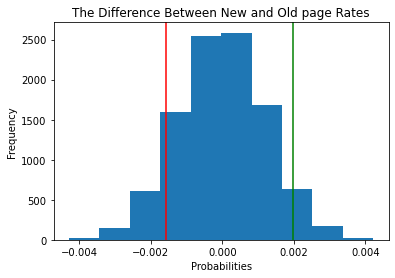

In [31]:
plt.hist(p_diffs);
plt.axvline(x=obs_diff , color = 'r')
plt.title("The Difference Between New and Old page Rates")
plt.xlabel("Probabilities")
plt.ylabel("Frequency")
plt.axvline(np.percentile(p_diffs , 95) , color = 'g')

In [32]:
p_diffs=np.array(p_diffs)

**j.** What proportion of the **p_diffs** are greater than the actual difference observed in the `df2` data?

In [33]:
p = (p_diffs > obs_diff).mean()
print(round(p,4))

0.9005


**k.** Please explain in words what you have just computed in part **j** above.  
 - What is this value called in scientific studies?  
 - What does this value signify in terms of whether or not there is a difference between the new and old pages? *Hint*: Compare the value above with the "Type I error rate (0.05)". 

>**I calculated the p-value if the null hypothesis is true then
the actual difference observed in the df2 dataframe is (obs_diff) that we calculated earlier ....
so the proportion of the p_diffs are greater than will be the mean of p_diffs > obs_diff ....
p-value = 0.905**



**l. Using Built-in Methods for Hypothesis Testing**<br>
We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. 

Fill in the statements below to calculate the:
- `convert_old`: number of conversions with the old_page
- `convert_new`: number of conversions with the new_page
- `n_old`: number of individuals who were shown the old_page
- `n_new`: number of individuals who were shown the new_page


In [34]:
import statsmodels.api as sm

# number of conversions with the old_page
convert_old = df2.query("converted==1 & landing_page =='old_page'").shape[0]

# number of conversions with the new_page
convert_new =  df2.query("converted==1 & landing_page =='new_page'").shape[0]

# number of individuals who were shown the old_page
n_old = df2.query("landing_page =='old_page'").shape[0]

# number of individuals who received new_page
n_new = df2.query("landing_page =='new_page'").shape[0]



In [35]:
the_results_from_I = "The converted_old is {} , convert_new is {} , n_old is {} and n_new  is {} " .format(convert_old,convert_new,n_old,n_new)
print(the_results_from_I )

The converted_old is 17489 , convert_new is 17264 , n_old is 145274 and n_new  is 145310 



The syntax is: 
```bash
proportions_ztest(count_array, nobs_array, alternative='larger')
```
where, 
- `count_array` = represents the number of "converted" for each group
- `nobs_array` = represents the total number of observations (rows) in each group
- `alternative` = choose one of the values from `[‘two-sided’, ‘smaller’, ‘larger’]` depending upon two-tailed, left-tailed, or right-tailed respectively. 

The built-in function above will return the z_score, p_value. 

---
### About the two-sample z-test
Recall that you have plotted a distribution `p_diffs` representing the
difference in the "converted" probability  $(p{'}_{new}-p{'}_{old})$  for your two simulated samples 10,000 times. 

Another way for comparing the mean of two independent and normal distribution is a **two-sample z-test**. You can perform the Z-test to calculate the Z_score, as shown in the equation below:

$$
Z_{score} = \frac{ (p{'}_{new}-p{'}_{old}) - (p_{new}  -  p_{old})}{ \sqrt{ \frac{\sigma^{2}_{new} }{n_{new}} + \frac{\sigma^{2}_{old} }{n_{old}}  } }
$$

where,
- $p{'}$ is the "converted" success rate in the sample
- $p_{new}$ and $p_{old}$ are the "converted" success rate for the two groups in the population. 
- $\sigma_{new}$ and $\sigma_{new}$ are the standard deviation for the two groups in the population. 
- $n_{new}$ and $n_{old}$ represent the size of the two groups or samples (it's same in our case)


>Z-test is performed when the sample size is large, and the population variance is known. The z-score represents the distance between the two "converted" success rates in terms of the standard error. 

Next step is to make a decision to reject or fail to reject the null hypothesis based on comparing these two values: 
- $Z_{score}$
- $Z_{\alpha}$ or $Z_{0.05}$, also known as critical value at 95% confidence interval.  $Z_{0.05}$ is 1.645 for one-tailed tests,  and 1.960 for two-tailed test. You can determine the $Z_{\alpha}$ from the z-table manually. 

Decide if your hypothesis is either a two-tailed, left-tailed, or right-tailed test. Accordingly, reject OR fail to reject the  null based on the comparison between $Z_{score}$ and $Z_{\alpha}$. We determine whether or not the $Z_{score}$ lies in the "rejection region" in the distribution. In other words, a "rejection region" is an interval where the null hypothesis is rejected iff the $Z_{score}$ lies in that region.

---

In [36]:
import statsmodels.api as sm
# ToDo: Complete the sm.stats.proportions_ztest() method arguments
count_array = np.array([convert_new, convert_old])
nobs_array = np.array([n_old, n_new])


z_score, p_value = sm.stats.proportions_ztest([convert_new, convert_old], [n_new, n_old], alternative='two-sided')

print("this is z_score {}".format(z_score))
print("this is p_value {}".format(p_value))


this is z_score -1.3109241984234394
this is p_value 0.18988337448195103


**n.** What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?<br><br>

z-score = (obs_diff 2) standard deviation .......... z-score and p-value values agree with what we got in the previous question in j and k p_value = 0.18988337448195103 ................. we can not reject our null hypothesis

<a id='regression'></a>
### Part III - A regression approach

In this final part, you will see that the result you achieved in the A/B test in Part II above can also be achieved by performing regression.<br><br> 

**Since each row in the `df2` data is either a conversion or no conversion, what type of regression should you be performing in this case?**

Since we are dealing  with binary outputs , the type of regression is logistic regression 

**b.** The goal is to use **statsmodels** library to fit the regression model you specified in part **a.** above to see if there is a significant difference in conversion based on the page-type a customer receives. However, you first need to create the following two columns in the `df2` dataframe:
 1. `intercept` - It should be `1` in the entire column. 
 2. `ab_page` - It's a dummy variable column, having a value `1` when an individual receives the **treatment**, otherwise `0`.  

In [42]:
df2['intercept'] =1

In [43]:
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1


In [44]:
df2= df2.join(pd.get_dummies(df2['landing_page']))

In [45]:
df2['ab_page'] = pd.get_dummies(df2['group']) ['treatment']
df2.head()


,user_id,timestamp,group,landing_page,converted,intercept,new_page,old_page,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,1,0


**c.** Use **statsmodels** to instantiate your regression model on the two columns you created in part (b). above, then fit the model to predict whether or not an individual converts. 


In [46]:
f_model = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])
result4f_m = f_model.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


**d.** Provide the summary of your model below, and use it as necessary to answer the following questions.

In [47]:
result4f_m.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Pseudo R-squared: 0.000      
Dependent Variable: converted        AIC:              212780.3502
Date:               2022-08-15 23:09 BIC:              212801.5095
No. Observations:   290584           Log-Likelihood:   -1.0639e+05
Df Model:           1                LL-Null:          -1.0639e+05
Df Residuals:       290582           LLR p-value:      0.18988    
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9888    0.0081  -246.6690  0.0000  -2.0046  -1.9730
ab_page      -0.0150    0.0114    -1.3109  0.1899  -0.0374   0.0074
==================================================================

"""

**e.** What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  


*we have two different values in part2 and 3 because in part 2 it was 1 tail and in part3 the linear regression depend on two-sided test.
*P-value is still greater that error rate so we can not reject the null hypothesi.
*p_value = 0.1899.


**f.** Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

**The more we get the more we give ..... if we get extra informations like Age , social statu , education level , jop title or total income .. all of the above will definitely have an effect an indiviual converts.

**g. Adding countries**<br> 
Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives in. 

1. You will need to read in the **countries.csv** dataset and merge together your `df2` datasets on the appropriate rows. You call the resulting dataframe `df_merged`. [Here](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.join.html) are the docs for joining tables. 

2. Does it appear that country had an impact on conversion?  To answer this question, consider the three unique values, `['UK', 'US', 'CA']`, in the `country` column. Create dummy variables for these country columns. 



In [48]:
# Read the countries.csv
countries=pd.read_csv('countries.csv')
countries.head()

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [49]:
# Join with the df2 dataframe
df3 = countries.set_index('user_id').join(df2.set_index('user_id'),how ='inner')

In [50]:
df3['intercept'] =1

In [51]:
pd.get_dummies(df3['country']).head()

,CA,UK,US
user_id,,,
834778,0,1,0
928468,0,0,1
822059,0,1,0
711597,0,1,0
710616,0,1,0


In [52]:
# Create the necessary dummy variables
df3[['UK','US','CA']]=pd.get_dummies(df3['country'])
df3.head()

,country,timestamp,group,landing_page,converted,intercept,new_page,old_page,ab_page,UK,US,CA
user_id,,,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,1,0,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,1,0,0,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,0,1,0,1,0
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0,1,0,0,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,0,1,0,1,0


In [53]:
df3['US_inter'] = df3['US'] * df3['ab_page']
df3['UK_inter'] = df3['UK'] * df3['ab_page']

In [54]:
p4usconverted=df3.query("converted==1 & country=='US'").shape[0]/df3['converted'].count()
p4ukconverted=df3.query("converted==1 & country=='UK'").shape[0]/df3['converted'].count()
p4caconverted=df3.query("converted==1 & country=='CA'").shape[0]/df3['converted'].count()

print("The convertion for US is {} , for UK {} and for CA {} ".format(round(p4usconverted,4) , round(p4ukconverted,4) , round(p4caconverted,4)))


The convertion for US is 0.0838 , for UK 0.0301 and for CA 0.0058 


**h. Fit your model and obtain the results**<br> 
Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if are there significant effects on conversion.  **Create the necessary additional columns, and fit the new model.** 


Provide the summary results (statistical output), and your conclusions (written response) based on the results. 

>**Tip**: Conclusions should include both statistical reasoning, and practical reasoning for the situation. 

>**Hints**: 
- Look at all of p-values in the summary, and compare against the Type I error rate (0.05). 
- Can you reject/fail to reject the null hypotheses (regression model)?
- Comment on the effect of page and country to predict the conversion.


In [55]:
# Fit your model, and summarize the results
f_model = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])
result4f_m = f_model.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


In [56]:

_2nd_model = sm.Logit(df3['converted'], df3[['intercept', 'US', 'UK' ,'ab_page' , 'US_inter', 'UK_inter']])
result4_2nd_m = _2nd_model.fit()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


In [57]:
result4_2nd_m.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Pseudo R-squared: 0.000      
Dependent Variable: converted        AIC:              212782.6602
Date:               2022-08-15 23:09 BIC:              212846.1381
No. Observations:   290584           Log-Likelihood:   -1.0639e+05
Df Model:           5                LL-Null:          -1.0639e+05
Df Residuals:       290578           LLR p-value:      0.19199    
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9865    0.0096  -206.3440  0.0000  -2.0053  -1.9676
US           -0.0057    0.0188    -0.3057  0.7598  -0.0426   0.0311
UK           -0.0175    0.0377    -0.4652  0.6418  -0.0914   0.0563
ab_page      -0.0206    0.0137    -1.5052  0.1323  -0.0473   0.0062
US_inter      0.0314    0.0266     1.1807  0.2377  -0.0207   0.0835
UK_inter     -0.0469    0.0538    -0.8718  0.3833  -0.1523   0.0585
==================================================================

"""

the p_value for ab_page = 0.1323 which still higher than error rate (0.05) so we also still can not reject the null hypothesi.

the effect of the new dataframe -countries- is not that significant on individual conversion

<a id='conclusion'></a>
## Conclusion

>**we don't have enough evidence that supports the new page is better than the old one .. I vote for the old page** 